In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.model_selection import cross_val_score
from IPython.display import display_html

In [2]:
def top_corrs(df, column, n=20):
    corr_df = df.corr()[[column]]
    corr_df.columns = ["corr"]
    corr_df["abs_corr"] = corr_df.abs()

    top_n_num = corr_df.sort_values("abs_corr", ascending=False).head(20)
    return top_n_num


def plot_top_corrs(df, column, n=10):
    top_corrs_df = top_corrs(df, column, n)
    top_feats = top_corrs_df.index
    top_corr = df[top_feats]
    top_corr_tall = pd.melt(top_corr, column)

    fg = sns.FacetGrid(top_corr_tall, col="variable", col_wrap=5, sharex=False)
    fg.map(sns.scatterplot, "value", column)
    plt.show()

In [3]:
# do any encoding before vif

def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [4]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [6]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

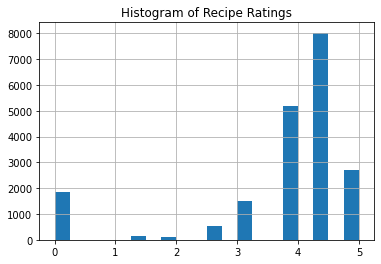

In [7]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [5]:
# Count the nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [6]:
#svr = SVR()
#X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
#Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
#svr.fit(X,Y)

SVR()

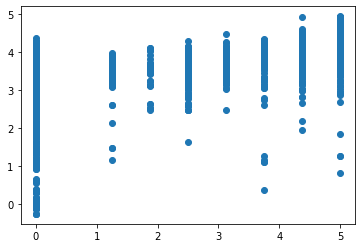

In [7]:
#plt.scatter(Y, svr.predict(X))

In [8]:
svr.score(X, Y)

0.40998459138007937

In [9]:
cross_val_score(svr, X, Y, cv=5)

array([0.19563385, 0.14683481, 0.15013401, 0.13597791, 0.16082192])

##  Will do some EDA below and run the model again using a binary rating target of is_high or not.

In [8]:
print(raw_data.rating.value_counts().sort_index())
print(raw_data.rating.nunique())

0.000    1836
1.250     164
1.875     124
2.500     532
3.125    1489
3.750    5169
4.375    8019
5.000    2719
Name: rating, dtype: int64
8


In [10]:
# creating binary where a rating of 4 or higher is a high rating

raw_data['high_rating'] = raw_data.rating.transform(lambda x: int(x >= 4))

In [11]:
df = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)

In [10]:
print(raw_data.high_rating.value_counts().sort_index())
print(raw_data.high_rating.nunique())

0     9314
1    10738
Name: high_rating, dtype: int64
2


Changing the problem to regression and using a binary of high rating of 4 or higher improved the model but will now remove correlated variables. 

In [12]:
top_corrs(df, column='high_rating', n=30)

,corr,abs_corr
high_rating,1.000000,1.000000
bon appétit,0.097076,0.097076
house & garden,-0.092801,0.092801
drink,-0.083065,0.083065
alcoholic,-0.077158,0.077158
gin,-0.071066,0.071066
roast,0.068198,0.068198
thanksgiving,0.067094,0.067094
peanut free,0.065897,0.065897
soy free,0.065799,0.065799


In [32]:
# running this code took 32 min (13515048 rows × 3 columns)
#pd.melt(df, id_vars =['high_rating']) 

,high_rating,variable,value
0,0,#cakeweek,0.0
1,1,#cakeweek,0.0
2,0,#cakeweek,0.0
3,1,#cakeweek,0.0
4,0,#cakeweek,0.0
...,...,...,...
13515043,0,turkey,0.0
13515044,1,turkey,0.0
13515045,1,turkey,1.0
13515046,1,turkey,0.0


In [13]:
X = df[['bon appétit','house & garden','drink','alcoholic','gin','roast','thanksgiving','peanut free','soy free',
       'cocktail party','dinner','spirit','christmas','bitters','grill/barbecue','low fat','tree nut free',
       'backyard bbq','fall']]
y = df['high_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [24]:
#c=5 lin was .55
#c=2 c=3 and c=5 rfb were .59 and .57

lin_model = SVC(C=2, degree=3, kernel="rbf")
lin_model.fit(X_train, y_train)

print(f"Train score: {lin_model.score(X_train, y_train)}")
print(f"Test score: {lin_model.score(X_test, y_test)}")

Train score: 0.5941863778854375
Test score: 0.5762965425531915


In [25]:
grid = {"degree": [1, 2, 3, 4, 5], "C": [0.1, 1, 10, 100]}

poly_model = GridSearchCV(SVC(kernel="poly"), grid, verbose=1, cv=2, n_jobs=-1)
poly_model.fit(X_train, y_train)

poly_model.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.8min finished


{'C': 1, 'degree': 3}

In [19]:
# tried running this twice and 3.5 hours later, I decided to run hyperparameters individually
#grid = {
#    "kernel": ["linear", "rbf", 'poly'],
#    "kernal": ["linear"],
#    "degree": [2, 3],
#    "gamma": [1, 10],
#    "C": [0.1, 1, 5],
#}

#model = GridSearchCV(SVC(), grid, verbose=1, cv=2, n_jobs=-1)
#model.fit(X_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ValueError: Invalid parameter kernal for estimator SVC(C=0.1). Check the list of available parameters with `estimator.get_params().keys()`.

In [26]:
poly_model.best_params_

{'C': 1, 'degree': 3}

In [27]:
def svm_fit_score_plot(**kwargs):
    print(kwargs)

    poly_model = SVC(**kwargs)
    poly_model.fit(X_train, y_train)

    print(f"\nTrain score: {poly_model.score(X_train, y_train)}")
    print(f"Test score: {poly_model.score(X_test, y_test)}")

    plot_decision_regions(X_train, y_train, clf=poly_model, scatter_kwargs={"alpha": 0.05})
    plt.show()

In [28]:
svm_fit_score_plot(kernel="poly", C=1, degree=3)

{'kernel': 'poly', 'C': 1, 'degree': 3}

Train score: 0.591265317754346
Test score: 0.574468085106383


NameError: name 'plot_decision_regions' is not defined

After making the target, rating, a binary (high_rating) and changing from SVR to SVC, the model improved from 0.40998459138007937 with cv=5 (array([0.19563385, 0.14683481, 0.15013401, 0.13597791, 0.16082192])) to .5912 training score and .5744 testing score using a grid searched kernal='poly' with c=1 and degree 3. 

The change from regression to classification also included reducing the number of features down to the most correlated 30 features which also helped increase the score. 

This sample, as noted is likely biased because only many poor performing recipes go unrated as the distribution of ratings might suggest. The dataset is biased toward people liking a recipe and rating it highly vs. those who don't like a recipe and don't rate it at all. Many very bad recipes are also likely give a score of zero as shown in the distribution as well.